Над проектом работали:  
- Александр Калашников  
- Валентин Миронов  
- Елизавета Бердина  

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

In [2]:
TS = pd.read_excel("./Project 2_2022.xlsx", sheet_name="Data")
TS.Date = TS.Date.apply(pd.Timestamp)
TS = TS.set_index("Date")
TS = TS.drop(TS[TS.Balance == 0].index)

In [3]:
TS.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721


## Anomalies

Модуль обнаружения аномалий в данных. Работает на основе квантильного коридора и процентного отклонения.

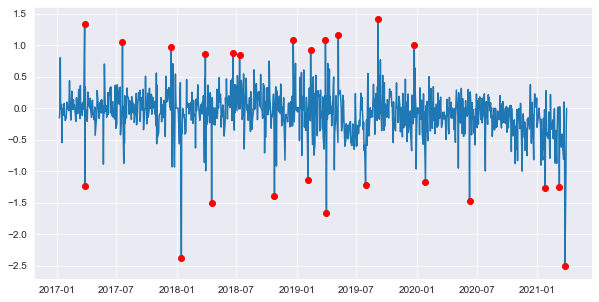

In [4]:
from modules.anomaly import detect_anomalies

anomaly_indexes = detect_anomalies(TS.Balance, thres=0.01, visualize=True)

## Changepoint

Делаем предположение, что тип разладки - смена волатильности, поэтому для обнаружения разладки используем статистику Ширяева-Роберста.

'anomaly'

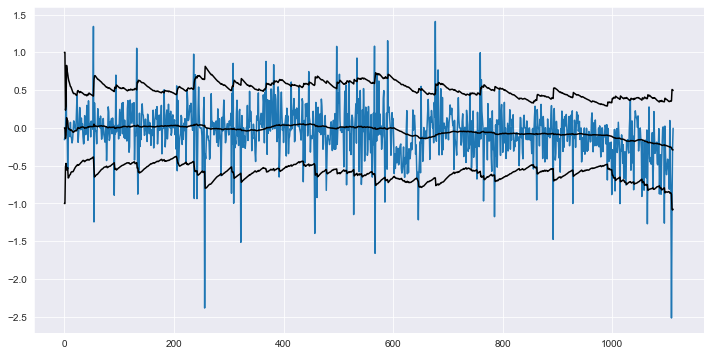

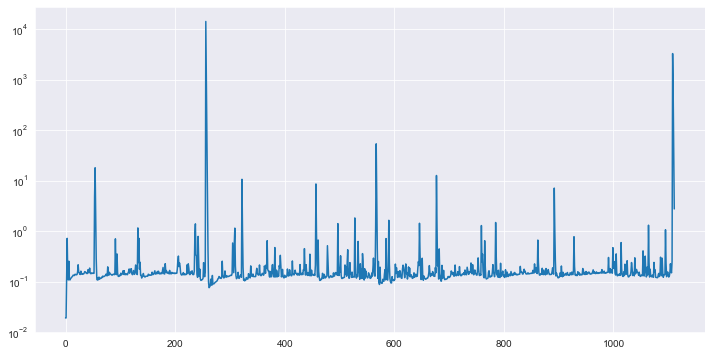

In [5]:
from modules.сhange_point_detection import detection_change_point, add_training_change_point

stat_trajectory = detection_change_point(TS.Balance, visualize=True)
add_training_change_point(stat_trajectory)

## Generator

Для генерации признакового пространства был использован модуль tsfresh. Дополнительными фичами были: налоговый календарь с мягким кодированием признака для того, чтобы учесть задержки выплат; макроэкономические факторы: нефть, доллар, индекс Мосбиржи; датированные признаки.

In [8]:
from modules.feature_generation import generate_features

X, y = generate_features(TS[["Balance"]], max_timeshift=14, min_timeshift=7)

Feature Extraction: 100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


## Selector

**Методы отбора:**
    Встроенные: случайный лес, lgbm.
    Обёрточные: рекурсивный метод иллюминации признаков на основе линейной регрессии
    Фильтрационные: метод на основе корреляций признаков (библиотека mufs), метод на основе взаимной информации (sklearn, но есть лучшая альтернатива CMICOT от Яндекса).

In [9]:
from modules.feature_selection import select_features, test_stability

selected_features = select_features(X, y)

Стабильность методов проверялась на основе метрики nogueira и тестированию на случайных подвыборках.

In [10]:
stability = test_stability(X, y, n_iterations=10)
stability

100%|██████████| 10/10 [01:31<00:00,  9.15s/it]


{'OLS recursive': 0.21668349252610997,
 'correlation': 0.6237837837837837,
 'mutual_info': 0.4063299663299663,
 'random_forest': 0.7314958246532415,
 'lgbm': 0.7375472050415108,
 'ensemble': 0.6833663827212215}

## Tuner

Для обеспечения автоматического дообучения без ручных корректировок применяем автоматический оптимизатор гиперпараметров Optuna.

In [15]:
from IPython.display import clear_output

from modules.tuner import tune

study = tune(X[X.columns[selected_features["lgbm"]]], y)
clear_output()

In [16]:
study.best_params

{'n_estimators': 600,
 'learning_rate': 0.24928609025944287,
 'num_leaves': 80,
 'max_depth': 3,
 'min_data_in_leaf': 53}

## Modeller

В качестве основной модели был выбран градиентный бустинг, обучаемый с опорой на бизнесовую метрику PnL на валидации

In [17]:
from modules.train import train_model

[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
Best MAE: 0.293462300409158
Best PnL: -0.49223421107759796


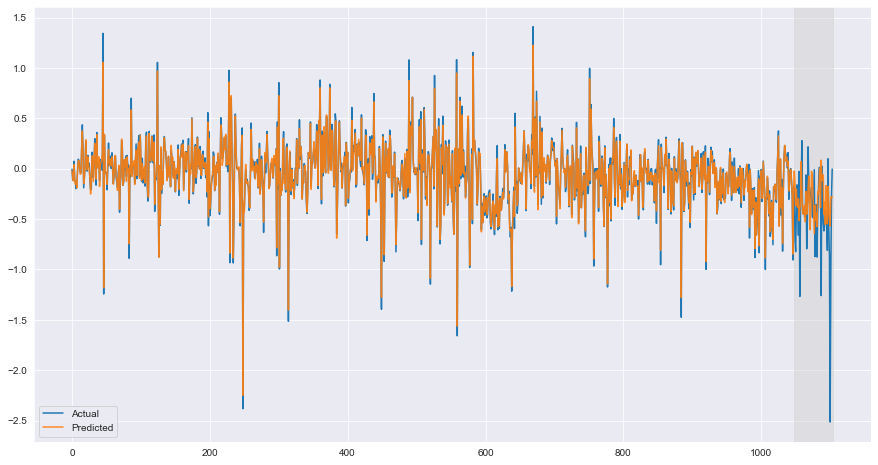

In [19]:
model_params = study.best_params

model = train_model(
    X[X.columns[selected_features["lgbm"]]], y,
    test_size=0.05, visualize=True,
    **model_params
)

## Pipeline

#### Пример workflow графа пайплайна

<img src="https://i.ibb.co/9yVjfBr/2022-05-22-19-07-54.png" width="1150" height="500">

Период калибровки выбирался на основе оценки качества работы модели в зависимости от пареметров max_timeshift=14, min_timeshift=7 в модуле генерации признакового пространства. max_timeshift - min_timeshift = 7 и явился лучшим периодом.

#### Предложение по работе пайплайна в продакшне

<img src="https://i.ibb.co/qnpj44v/2022-05-22-19-53-48.png" width="1150" height="700">

Формализуем предложенный граф пайплайна через известные технологии. Представим каждый узел графа в виде отдельного контейнезированного приложения. Каждый контейнер будет связываться с соседями через очереди сообщений. Ребро - одна очередь менеджера очередей. Также предлагается связать узлы графа очередями другого менеджера для возможности независимого обращения к ним и проверки состояния.

Предложенная архитектура обладает свойствами атомарности, устойчивости и персистентности передаваемых и исследуемых данных. Обеспечивает удобный мониторинг и предоставляет удобный способ оповещений о работе системы.

**Пример кода будет в отдельном репозитории, чтобы не захламлять этот:** https://github.com/sleep3r/ts-pipeline